# Semantic Segmentation of Water using U-Net
# Part 3 - Model building and Baseline Evaluation


In this part I will build a FCNN model to perform the semantic segmentation and evaluate the performance to get a baseline.

In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import concatenate, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, save_img
import numpy as np
import json, os
from random import shuffle
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import warnings
import re
import time

## U-Net Model

The U-Net architecture operates like an AutoEncoder with an encoding or contracting path and a decoding or expanding path. In a U-Net, long skip connections are added between the two paths which allows the decoding path to recover finer grained detail from the encoding path. Finally it tries to predict classes based on a corresponding mask image.

The following images shows the architecture of a U-Net as implemented by [Ronneberger et al.](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/) for the segmentation of medical images. They use an input of 572 x 572 x 1 i.e. greyscale image and output a segmentation image of 388 x 388 x 2 with the 2 channels representing the foreground and background respectively.

![](notebook_images/u-net-architecture.png)

This will be the basis of my implementation but I will make a few changes:
- Input image size - Ronneberger et al. used single channel grayscale inputs whereas I am using 3-channel RGB data
- Padding - Ronneberger et al. did not use any padding in their convolutional layers, reducing the image dimensions with the resulting classification being smaller than the input. In my case I want to classify every single pixel and output a classification that is the same size as the input. Therefore I will use padding.
- Output channels - Ronneberger et al. used two channels for their output representing background and objects. I will use just one output channel where each value is the probability that the pixel is water - this can then be thresholded to produce a binary classification map.

To allow me to configure the model in a range of different ways I will include some extra arguments in the model definition.

In [2]:
def UNet(input_shape=(256, 256, 3), n_filters=64, n_blocks=4, model_name='UNet'):
    """Creates UNet Model
    
    Creates a UNet architecture a la
    Olaf Ronneberger et al.
    
    Parameters
    ----------
    input_shape: tuple of int:
        The dimensions of the input images in the form
        (H,W,C).
    n_filters: int, optional
        The number of filters to use in the first convolution
        block. Default is 64 as used in Ronneberger et al.
    n_blocks: int, optional
        The number of blocks implemented on each path. Default
        is 4 as used in Ronneberger et al.
    model_name: string, optional
        A name to assign to the model.
        
    Returns
    -------
    tensorflow.keras.models.Model:
        The configured U-Net model.
    """
    
    # Reference to input layer
    in_ = Input(input_shape)
    
    # Copy input layer for operations
    x = in_
    
    # Blocks on each side of the UNet architecture
    blocks = n_blocks
    
    # Keep track of layers for concatenation on the DECODE side
    concat_layers = []
    
    ## ---- ENCODER ----
    # An encoder block consists of CONV2D=>CONV2D=>MAXPOOL
    enc_filters = n_filters
    for block in range(blocks):
        
        # Block of Conv2D & MaxPooling2D
        x = Conv2D(filters=enc_filters, kernel_size=(3, 3), activation='relu', padding='same')(x)
        x = Conv2D(filters=enc_filters, kernel_size=(3, 3), activation='relu', padding='same')(x)
        
        # Append to layer list for concatenation
        concat_layers.append(x)
        
        x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')(x)
        
        # Increase number of filters
        enc_filters *= 2
        
    # Final Conv2D before upsampling
    x = Conv2D(filters=enc_filters, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = Conv2D(filters=enc_filters, kernel_size=(3, 3), activation='relu', padding='same')(x)
    
    
    ## ---- DECODER ---- ##
    # A decoder block consists of CONV2DTRANS=>CONCAT=>CONV2D=>CONV2D
    dec_filters = enc_filters / 2
    for block in range(blocks):
        
        # Block of Conv2DTranspose, Concatenate & Conv2D
        x = Conv2DTranspose(dec_filters, kernel_size=(2,2), strides=(2, 2), padding='same') (x)
    
        # Concatenate with corresponding layer output from the encoding side of
        # the UNet.    
        concat = concatenate([concat_layers.pop(), x], axis=3)
        
        x = Conv2D(filters=dec_filters, kernel_size=(3, 3), activation='relu', padding='same')(concat)
        x = Conv2D(filters=dec_filters, kernel_size=(3, 3), activation='relu', padding='same')(x)
    
        dec_filters /= 2
    
    # ---- OUTPUT ----
    # Output a single channel with the probabilty that the pixel
    # is the positive class e.g. foreground, water etc.
    out_ = Conv2D(1, 1, activation='sigmoid')(x)
    
    model_name = f'{model_name}_f{n_filters}_b{n_blocks}'
    model = Model(inputs=in_, outputs=out_, name=model_name)
    
    return model

In [3]:
# I'll start with a simpler version of the model that can be trained quickly to
# provide a baseline and some insight into what improvements to make.
model = UNet(n_filters=32, n_blocks=2, model_name='baseline')
print(model.name)
model.summary()

baseline_f32_b2
Model: "baseline_f32_b2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d_1[0][0]                   
____________________________________________________________________

## Baseline Evaluation

To evaluate ther performance of this model I need some data! I will use the functions defined earlier which are incorporated into my `unetlib` library.

In [4]:
from unetlib.preprocessing import make_dataframes_for_flow, make_img_datagen
from unetlib import visualisation as vs

In [5]:
# Imagery directories
nwpu_data_dir = 'nwpu_lake_images/data/'
nwpu_mask_dir = 'nwpu_lake_images/masks/'

In [6]:
# Split the test/train data
train_img_df, train_msk_df, test_img_df, test_msk_df, = make_dataframes_for_flow(nwpu_data_dir,
                                                                                 nwpu_mask_dir,
                                                                                 test_size=0.25,
                                                                                 random_state=42
                                                                                )

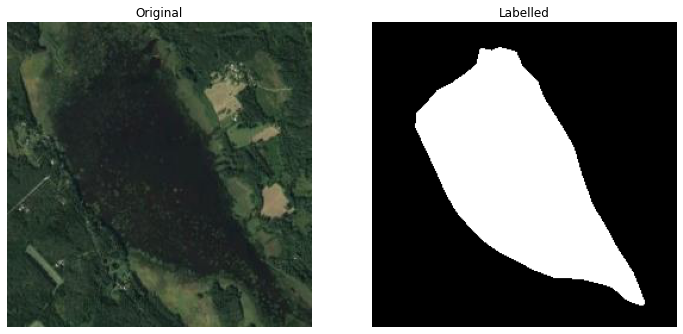

In [9]:
# Plot first image and mask pair of training data
vs.plot_labels(os.path.join(nwpu_data_dir, train_img_df.iat[0,0]),
               os.path.join(nwpu_mask_dir, train_msk_df.iat[0,0]),
               figsize=(12,6)
              )

In [10]:
# Split the training data into train and validation generators
train_gen, val_gen, train_fps, val_fps = make_img_datagen(train_img_df, train_msk_df,
                                                          nwpu_data_dir, nwpu_mask_dir,
                                                          val_split=0.3, rescale=1/255)

Found 210 validated image filenames.
Found 210 validated image filenames.
Found 90 validated image filenames.
Found 90 validated image filenames.


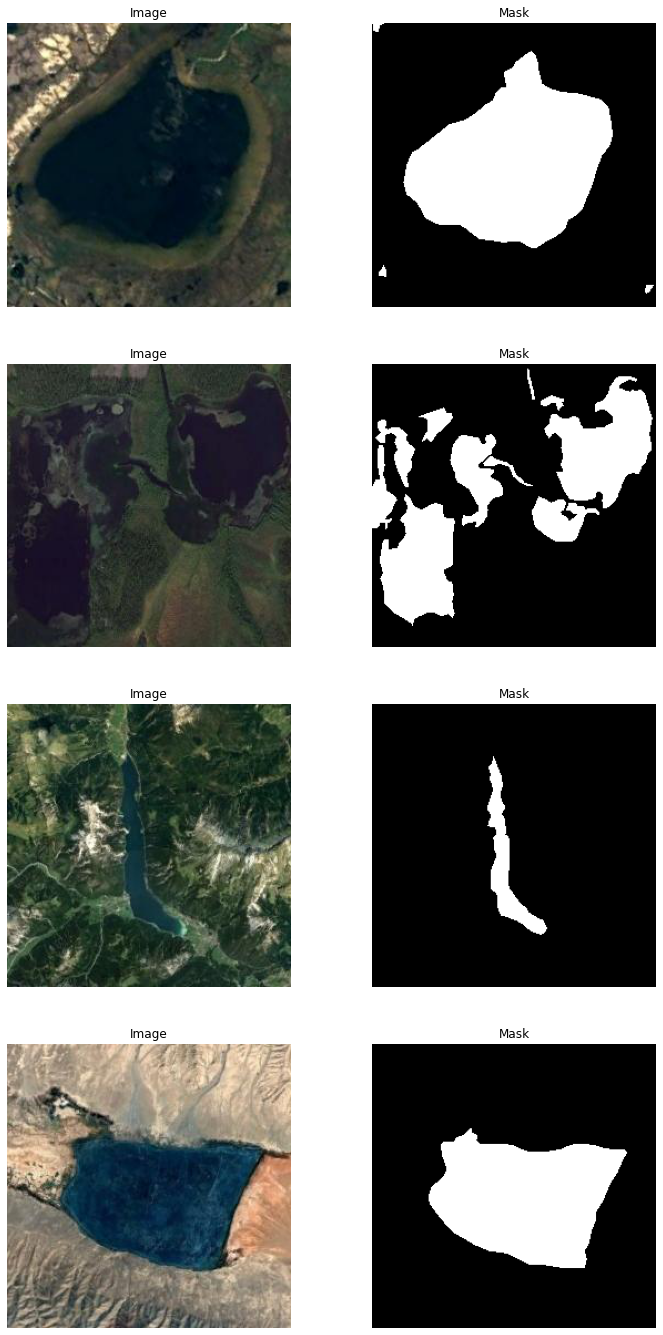

In [10]:
# Plot sample of train batch
train_batch = next(train_gen)
vs.plot_batch(*train_batch, n_images=4, figsize=(12,24))

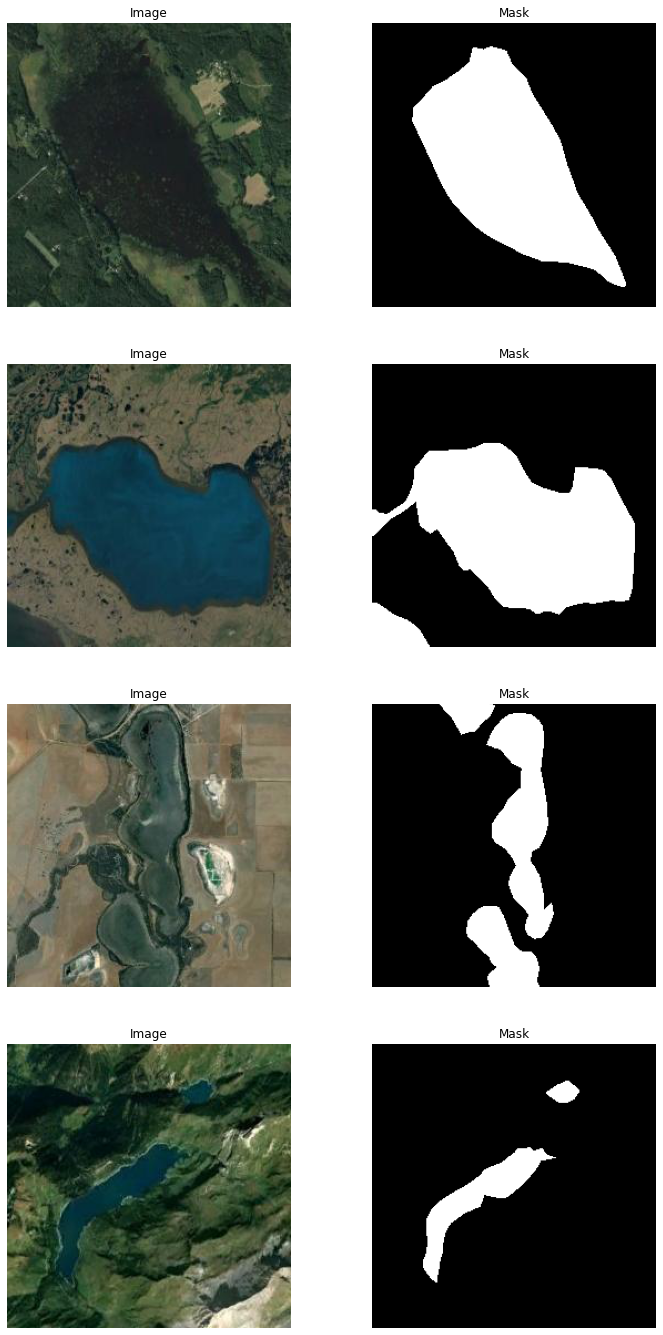

In [11]:
# Plot sample of validation batch
val_batch = next(val_gen)
vs.plot_batch(*val_batch, n_images=4, figsize=(12,24))

Now that the training and validation data are ready the next step is to compile the baseline model with a loss function, an optimiser and any other metrics.

For the **optimiser** I'm using RMSProp which is usally a good default for neural networks. I recommend reading [this](https://towardsdatascience.com/a-visual-explanation-of-gradient-descent-methods-momentum-adagrad-rmsprop-adam-f898b102325c) article for a summary of other options and parameters.

The **loss function** is used to compute the error between the model predictions and expected values - in this case the mask values 0 and 1. This is a binary classification on a per pixel basis so I'll use the Binary Cross Entropy loss function. For more information see [this](https://machinelearningmastery.com/loss-and-loss-functions-for-training-deep-learning-neural-networks/) article.

Finally, in terms of metrics I want to evaluate the **accuracy** of the model. However, care must be taken when deciding the accuracy measure as the standard method of calculating accuracy is sensitive to class imbalance. When it comes to semantic segmentation a common accuracy measure is the Intersection Over Union (IoU, or Jaccard Index). A good example of this metric and others for evaluating semantic segmentation can be found [here](https://medium.com/digitalbridge/how-we-use-image-semantic-segmentation-e85fac734caf). Helpfully the IoU is included in the Keras metrics.

However, the `MeanIoU` metric in keras assumes the input predictions have already been mapped to class indices i.e. 0 or 1 etc. Models for binary semantic segmentation typically end with a sigmoind activation representing the probability that the pixels belong to the foreground (water) class versus the background (non-water) class. Therefore the prediction values range from 0 to 1 and must be first mapped to 0 for background or 1 for foreground using a threshold (usually 0.5). I will therefore inherit from the `MeanIoU` class and apply a thresholding operation on the predictions prior to IoU calculation.

In [7]:
class BinaryMeanIoU(tf.keras.metrics.MeanIoU):
    """Computes the mean Intersection-Over-Union metric.
    
    The standard MeanIoU metric assumes the true values and
    predictions are integers corresponding to class numbers.
    However, in cases of binary semantic segmentation where
    networks end with a Sigmoid activation the outputs are
    floating point values between 0 and 1.
    
    This BinaryMeanIoU metric therefore accepts a threshold
    value used to map the Sigmoid activations to the classes
    prior to calculating the Mean IoU.
    
    
    Parameters
    ----------
    threshold: float, optional
        Probability threshold value. Values greater than or equal
        to this will be assigned to the positive class, 1. Default
        is 0.5.
    name: str, optional
         Name of the metric instance.
    dtype: TensorFlow data type, optional
    
    """
    def __init__(self, threshold=0.5, name=None, dtype=None):
        super(BinaryMeanIoU, self).__init__(num_classes=2, name=name, dtype=dtype)
        self.threshold = threshold
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        # If predictions are not floating point they are just passed through
        if y_pred.dtype.is_floating:
            # Apply the threshold value
            y_pred = tf.keras.backend.cast(y_pred > self.threshold, tf.int32)
        # Pass new y_pred to standard MeanIoU function
        super(BinaryMeanIoU, self).update_state(y_true, y_pred, sample_weight)

In [11]:
# Compile the model
model.compile(optimizer='RMSProp', # RMSProp is the default but included here for clarity 
              loss='binary_crossentropy',
              metrics=[BinaryMeanIoU(threshold=0.5)] # use default threshold of 0.5
             )

In [12]:
# Re-initialise the train and validation generators
# I'm using a smaller batch size for the training process
# to reduce the compute per batch at the expense of the
# number of batches required

batch_size = 16
train_gen, val_gen, train_fps, val_fps = make_img_datagen(train_img_df, train_msk_df,
                                                          nwpu_data_dir, nwpu_mask_dir,
                                                          val_split=0.3, rescale=1/255,
                                                          batch_size=batch_size
                                                         )

Found 210 validated image filenames.
Found 210 validated image filenames.
Found 90 validated image filenames.
Found 90 validated image filenames.


The data generators will not stop after yielding all images, they simply restart and continue cycling through them. When training a model it is up to the user to tell these generators to stop generating; at each epoch the model should see the entire dataset just once.

To know when to stop we must determine how many batches are required to capture the entire dataset. This is where the lists of filenames for the training and validation splits helps!

In [13]:
# Compute steps per epoch
train_steps = int(np.ceil(len(train_fps) / batch_size))
val_steps = int(np.ceil(len(val_fps) / batch_size))

print(f'Train Steps: {train_steps}')
print(f'Val Steps: {val_steps}')

Train Steps: 14
Val Steps: 6


If the number of images doesnt fit evenly between the batches then the last batch will have fewer images i.e. the remainder

In [16]:
len(train_fps) % batch_size

2

Finally I'm ready to train the model! For training I am constrained by my personal machine so opted to use Paperspace's [Gradient](https://gradient.run/) platform. This offers free GPU usage and the ability to easily upload data, notebooks and custom libraries (such as my `unetlib` package).

[Kaggle](https://www.kaggle.com) is perhaps the more popular option and at present has a more popwerful GPU available. However, uploading data and notebooks can be cumbersome and there is no option to upload .py files so the code must be contained to one notebook.

The following cells should be run on a GPU instance.

In [14]:
# Number of times to cycle the full training set
epochs = 100

In [ ]:
# Train the model and record the time taken
    
t1 = time.time()
history = model.fit(train_gen, epochs=epochs, steps_per_epoch=train_steps,
                    validation_data=val_gen, validation_steps=val_steps)
runtime = time.time() - t1

In [ ]:
# How many minutes did training take?
print(runtime / 60)

In [15]:
# configure model output directory and filenames
output_dir = 'model_outputs'
os.makedirs(output_dir, exist_ok=True)

hist_filepath = os.path.join(output_dir,
                             f'{model.name}_bs{batch_size}e{epochs}.history.pickle')

weights_filepath = os.path.join(output_dir,
                                f'{model.name}_bs{batch_size}e{epochs}.weights.h5')

In [ ]:
# Save history to pickle
with open(hist_filepath, 'wb') as f:
    pickle.dump(history.history, f)
    
# Save model weights
model.save_weights(weights_filepath)

With the baseline model now trained I'll examine the learning curves to get a better understanding of the training process.

In [16]:
# Load history if not already available
with open(hist_filepath, 'rb') as f:
    history = pickle.load(f)

In [17]:
# Create a DataFrame to examine the metrics
hist_df = pd.DataFrame(history)
hist_df

,loss,binary_mean_io_u,val_loss,val_binary_mean_io_u
0,0.950440,0.423101,0.398939,0.770450
1,0.338701,0.679817,0.393070,0.702886
2,0.328790,0.693089,0.307612,0.770014
3,0.279852,0.751269,0.309648,0.770333
4,0.266194,0.764893,0.313642,0.762372
...,...,...,...,...
95,0.066755,0.929419,0.151018,0.867676
96,0.088078,0.914157,0.272560,0.780509
97,0.082770,0.915920,0.196703,0.840470
98,0.071255,0.926112,0.139457,0.874753


In [18]:
# Function to plot model history and highlight
# best loss values.

def plot_model_history(history, metrics=['loss'], best=['min'], title=None,
                       figsize=(20,10), n_cols=2):
    """Plot model training history.
    
    Creates a plot of the results of each metric on the training
    and validation data. "Best" values are highlighted according
    to the methods in `best`.
    
    Parameters
    ----------
    history: pd.DataFrame or dict
        A model's history in either dictionary or DataFrame
        format.
    metrics: list of str, optional
        List of metrics to plot, one per axis. By default only
        the loss/val_loss will be plotted
    best: list of str, optional
        Method for determining the best metric value. Must align
        with the metrics list i.e. metrics[0] will have its best
        value determined by best[0]. By default just the minimum
        is used for the loss metric. Options are "min" or "max".
    title: str, optional
        Title for the figure. Default setting is to use no title.
    figsize: tuple of int, optional
        Width and height of figure in inches. Default dimensions
        are (20, 10)
    n_cols: int, optional
        Number of columns to split the metrics over. Number of rows
        will be determined from this. Default is 2 columns
        
    Returns
    -------
    matplotlib.figure.Figure
        A figure containing the axes with the metrics.
    
    """
    
    if isinstance(history, pd.DataFrame):
        pass
        
    elif isinstance(history, dict):
        history = pd.DataFrame(history)
    
    else:
        raise TypeError('`history` must be dictionary or DataFrame object.')
        
    # Configure axes
    n_rows = int(np.ceil(len(metrics)/n_cols))
    fig, axes = plt.subplots(n_rows, n_cols,figsize=figsize)
    
    
    # Record what values are best for each metric
    if best is None or len(best) != len(metrics):
        raise ValueError('`best` must contain a method for each metric in `metrics`.')
    best_vals = {m:b for m,b in zip(metrics, best)}
    invalid_best = set(best_vals.values()).difference(set(['min','max']))
    if len(invalid_best) > 0:
        raise ValueError('`best` must contain either "min" or "max" '
                         f'but user specified: {",".join(invalid_best)}')
    
    # Plot the data
    for m, ax in zip(metrics, axes.ravel()):
        val_m = f'val_{m}'
        
        # plot metric and its validation counterpart
        history[[m, val_m]].plot(ax=ax)
        
        # Determine best x (epoch) and y (metric) values
        best_x = getattr(history[val_m], f'arg{best_vals[m]}')()
        best_y = getattr(history[val_m], best_vals[m])()
        
        # Plot best value and lines
        ax.plot([best_x] * 2, [0, best_y], color='g')
        ax.plot([0, best_x], [best_y] * 2)
        ax.scatter(best_x, best_y, s=100, marker='o',color='g')
        
        # Set the axis title
        ax.set_title((f'{m.capitalize()}\n{best_vals[m].capitalize()}'
                 f'@ Epoch:{best_x}, Val:{best_y:.4f}'))
        
        # Set the axis limits
        ax.set_ylim(0,1)
        ax.set_xlim(0,len(history))
        
    
    # Set figure title
    fig.suptitle(title)
    
    # Turn off any axes that do not have data
    for ax in axes.ravel():
        if not ax.has_data():
            ax.axis('off')
    
    return fig

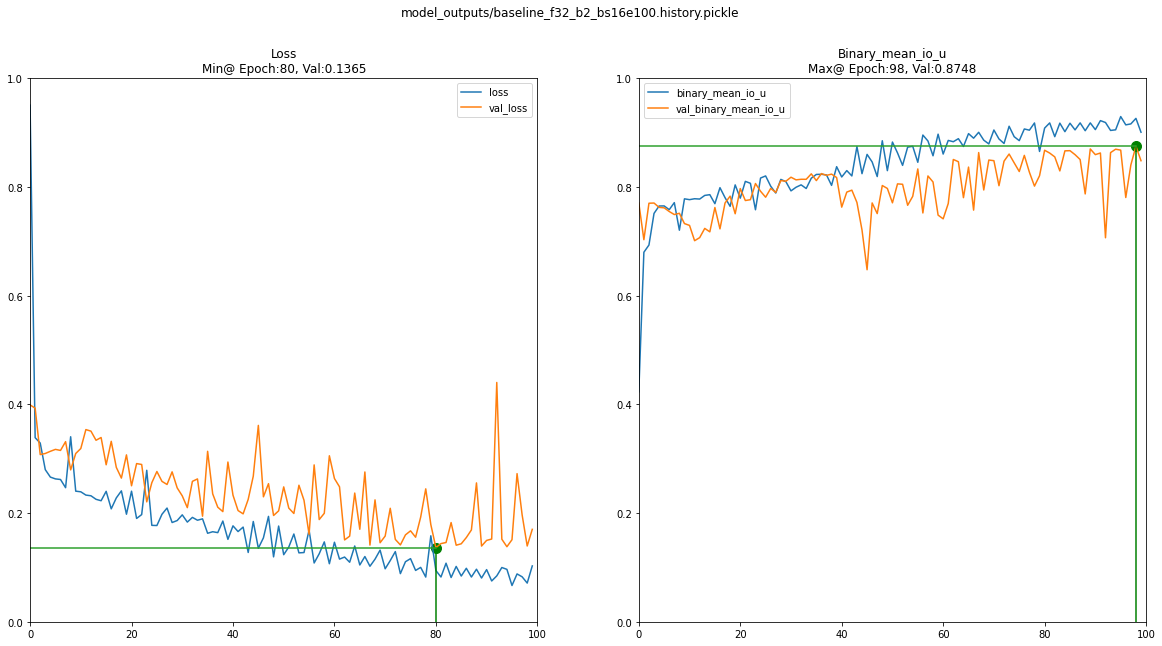

In [26]:
# Plot the training history
plot_model_history(hist_df, metrics=['loss', 'binary_mean_io_u'],
                       best=['min', 'max'], title=hist_filepath);

The Loss curves show that the training and validation losses are improving through the epochs, as is characteristic of these plots. At epoch 80 the validation loss reaches its best (minimum) value before flattening out. This plateau shows that the model has stopped improving. Conversely the training loss continues to show a downward trend. Similar behaviour can be seen in the binary mean IoU plot with the best (maximum) value for validation IoU of 87.48% occuring at epoch 98. However, it looks like between epoch 80 and 98 there is only a very small improvement.

The curves are rather noisy in the case which could be due to use a batch size that is too small. If the batches are not representative of the data then the performance per batch throughout the epoch can vary greatly.

While the IoU isnt bad, the overfitting means that the model is not getting better. In fact as it keeps learning and improves performance on the training data it can perform even worse on the validation data.

Overfitting can be due to the model being too powerful for the data and task or due to the use of a small dataset. These can be addressed by using a simpler model (or applying regularisation techniques) or increasing the amount of data.

I previously ran a simpler model composed of 2 blocks and 16 initial filters. I let this one train for 200 epochs due to it's simpler nature.

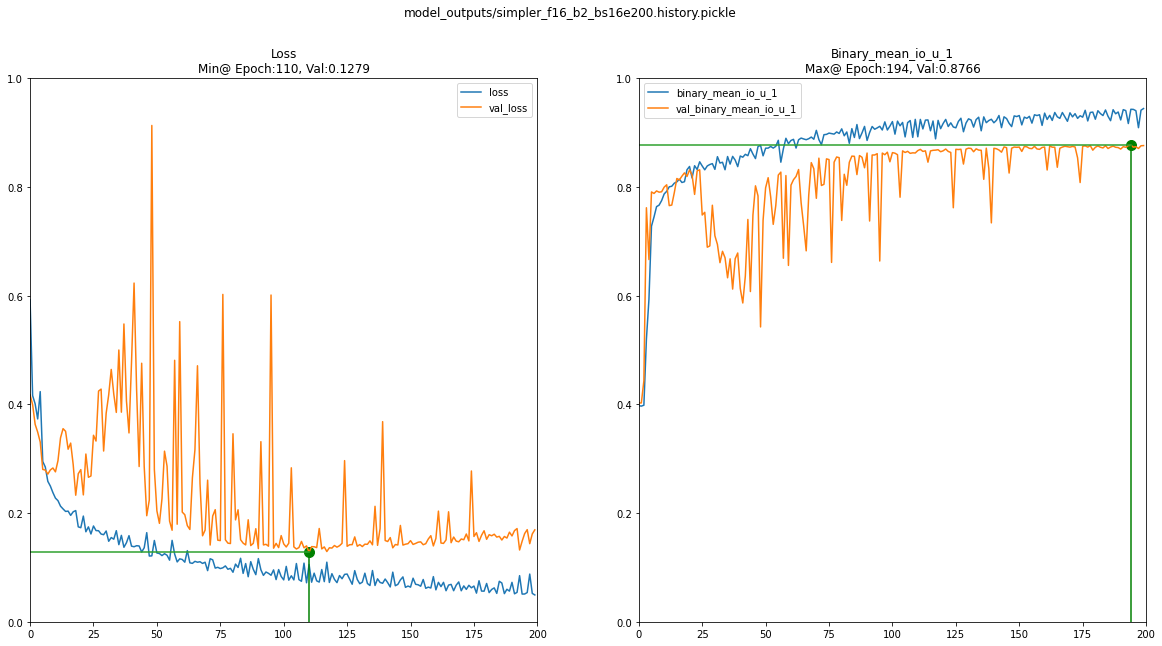

In [27]:
# Simpler model output
simple_hist_filepath = 'model_outputs/simpler_f16_b2_bs16e200.history.pickle'

# Load history if not already available
with open(simple_hist_filepath, 'rb') as f:
    simple_hist = pickle.load(f)
    
simple_hist_df = pd.DataFrame(simple_hist)

    
# Plot the training history
plot_model_history(simple_hist_df, metrics=['loss', 'binary_mean_io_u_1'],
                   best=['min', 'max'], title=simple_hist_filepath);

This simpler model reaches a lower `val_loss` than the baseline model and the accuracy improves ever so slightly to 87.66 %. By making the model a bit simpler it is not as quick to overfit to the later and shows a slight performance boost. However, as training contiues the model again starts to overfit the data.

Since I'm only working with a few hundred images in this case, I think it's a reasonable decision to focus on getting more data to combat overfitting. I could try to source more images myself and label those, or perhaps try to find another dataset that contains images of lakes. The main drawback here is that this can become very time consuming.

The approach that I will take is to use **data augmentation** to transform the current training images and artificially build up the dataset.